In [63]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from collections import Counter
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Embedding
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.models import load_model
from math import sqrt
import string
# from nltk.corpus import stopwords
import time
import sys
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wangjianxin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [231]:
data = pd.read_csv('review_rating.csv')

In [232]:
data  = data[:100000]
data

,Unnamed: 0,review_body,star_rating
0,1,"As a family allergic to wheat, dairy, eggs, nu...",5
1,2,"My favorite nut. Creamy, crunchy, salty, and ...",5
2,3,This green tea tastes so good! My girlfriend l...,5
3,4,I love Melissa's brand but this is a great sec...,5
4,5,good,5
...,...,...,...
99995,99996,This is absolutely the most savory brittle I h...,5
99996,99997,Exactly what I wanted,5
99997,99998,Not impressed,1
99998,99999,Yummy.,5


In [233]:
##Data preprocessing
##remove punctuation "!'&#;.......-👍🏻"

In [285]:
#convert into numpy arrays
# reviews = data[["review_body"]]
reviews = data.review_body.astype("str")
ratings = data.star_rating.values
reviews[0]

"As a family allergic to wheat, dairy, eggs, nuts, and several other things, we love the entire Cravings Place line of products as it allows us to bake treats with minimal effort and ingredients. Most allergy-free and gluten-free mixes usually just omit one or two allergens at most, so it's great to see a mix created without many of the most common allergens. (Note these still have soy and corn). We consume these on a regular basis and have been doing so for years."

In [286]:
#data preprocessing
rating_count = Counter()
for rating in ratings:
    rating_count[rating]+=1

#initialize 'num_min' with the value of rating_count's key = '1'.
num_min = rating_count[1]
for k in rating_count:
    if rating_count[k]<=num_min:
        num_min = rating_count[k]

print(rating_count,num_min)

#truncate the data to have equal amount across all ratings.
# one,two,three,four,five = 0,0,0,0,0
rating_list = np.array([0,0,0,0,0]) #namely rating = 1,2,3,4,5
end = np.array([num_min,num_min,num_min,num_min,num_min])
correct = np.array([1,1,1,1,1])
# a = rating_list/end
# print(rating_list/end == correct)
# sys.exit()
rev,ra = [],[]

for j,rating in enumerate(ratings):
    if all(rating_list == end):
        break

    for i,v in enumerate(rating_list):
        if v<num_min and i+1==rating:
            rev.append(reviews[j])
            ra.append(rating)
            rating_list[i]+=1

len(rev),len(ra)        
# reviews.shape,ratings.shape
reviews = np.array(rev)
ratings = np.array(ra)
# reviews = rev
# ratings = ra

Counter({5: 71603, 4: 11024, 1: 7079, 3: 6283, 2: 4011}) 4011


In [287]:
#remove punctuation and stop words
#lower case
# stop = stopwords.words('english')
# for i,text in enumerate(reviews):
# #     reviews[i] = [word.strip(string.punctuation) for word in text.split(" ")
# # text = text.lower()
#     reviews[i] = ' '.join([word.strip(string.punctuation).lower() for word in text.split(" ") if word not in stop and len(word) > 0])
   


reviews[0]

"As a family allergic to wheat, dairy, eggs, nuts, and several other things, we love the entire Cravings Place line of products as it allows us to bake treats with minimal effort and ingredients. Most allergy-free and gluten-free mixes usually just omit one or two allergens at most, so it's great to see a mix created without many of the most common allergens. (Note these still have soy and corn). We consume these on a regular basis and have been doing so for years."

In [288]:
count = Counter()
for review in reviews:
    for word in str(review).split():
        count[word]+=1

num_words = len(count)
print(num_words)
count

45424


Counter({'As': 247,
         'a': 16022,
         'family': 160,
         'allergic': 37,
         'to': 14104,
         'wheat,': 6,
         'dairy,': 9,
         'eggs,': 10,
         'nuts,': 28,
         'and': 16256,
         'several': 246,
         'other': 1406,
         'things,': 16,
         'we': 816,
         'love': 1386,
         'the': 24894,
         'entire': 79,
         'Cravings': 1,
         'Place': 2,
         'line': 55,
         'of': 11145,
         'products': 179,
         'as': 4334,
         'it': 10767,
         'allows': 20,
         'us': 105,
         'bake': 32,
         'treats': 29,
         'with': 4406,
         'minimal': 13,
         'effort': 17,
         'ingredients.': 55,
         'Most': 68,
         'allergy-free': 1,
         'gluten-free': 32,
         'mixes': 42,
         'usually': 209,
         'just': 2500,
         'omit': 2,
         'one': 1854,
         'or': 2222,
         'two': 529,
         'allergens': 3,
         'at': 2

In [289]:
max_len = 300

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(reviews)
word_index = tokenizer.word_index
len(word_index)

18275

In [290]:
review_to_seq = tokenizer.texts_to_sequences(reviews)
review_to_seq[1]

[15, 194, 813, 681, 526, 361, 3, 496, 111, 57, 52, 117, 26, 1368, 11]

In [291]:
reviews[1]

'My favorite nut.  Creamy, crunchy, salty, and slightly sweet - what more could you ask for?'

In [292]:
padded_reviews = pad_sequences(review_to_seq, maxlen=max_len)
padded_reviews[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [293]:
train_data = padded_reviews[:int(0.8*padded_reviews.shape[0])]
test_data = padded_reviews[int(0.8*padded_reviews.shape[0]):]
train_target = ratings[:int(0.8*ratings.shape[0])]
test_target = ratings[int(0.8*ratings.shape[0]):]
train_data.shape,test_data.shape,train_target.shape,test_target.shape

((16044, 300), (4011, 300), (16044,), (4011,))

In [295]:
## LSTM model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(len(word_index)+1, embedding_vecor_length, input_length=max_len))
model.add(LSTM(200))
model.add(Dense(1, activation='linear'))
print(model.summary())



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 300, 32)           584832    
                                                                 
 lstm_6 (LSTM)               (None, 200)               186400    
                                                                 
 dense_6 (Dense)             (None, 1)                 201       
                                                                 
Total params: 771,433
Trainable params: 771,433
Non-trainable params: 0
_________________________________________________________________
None


In [296]:
start = time.time()
adam = Adam(learning_rate = 1e-4)
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="./lstm.hdf5", verbose=0, save_best_only=True)
m = model.fit(
            train_data,
            train_target,
            batch_size=256,
            verbose=1,
            epochs=10,
            validation_split=0.2,
            shuffle=True, 
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/10
51/51 [==============================] - 59s 1s/step - loss: 10.5948 - val_loss: 3.7788
Epoch 2/10
51/51 [==============================] - 58s 1s/step - loss: 2.1255 - val_loss: 2.1153
Epoch 3/10
51/51 [==============================] - 60s 1s/step - loss: 2.0877 - val_loss: 2.5133
Epoch 4/10
51/51 [==============================] - 75s 1s/step - loss: 2.0674 - val_loss: 2.5562
Epoch 5/10
51/51 [==============================] - 67s 1s/step - loss: 2.0404 - val_loss: 2.4821
Epoch 6/10
51/51 [==============================] - 67s 1s/step - loss: 2.0026 - val_loss: 2.6212
Epoch 7/10
51/51 [==============================] - 61s 1s/step - loss: 1.9376 - val_loss: 2.3035
Epoch 8/10
51/51 [==============================] - 58s 1s/step - loss: 1.8506 - val_loss: 2.3053
Epoch 9/10
51/51 [==============================] - 59s 1s/step - loss: 1.7312 - val_loss: 2.1311
Epoch 10/10
51/51 [==============================] - 61s 1s/step - loss: 1.5617 - val_loss: 1.6513
Finish trainning. 

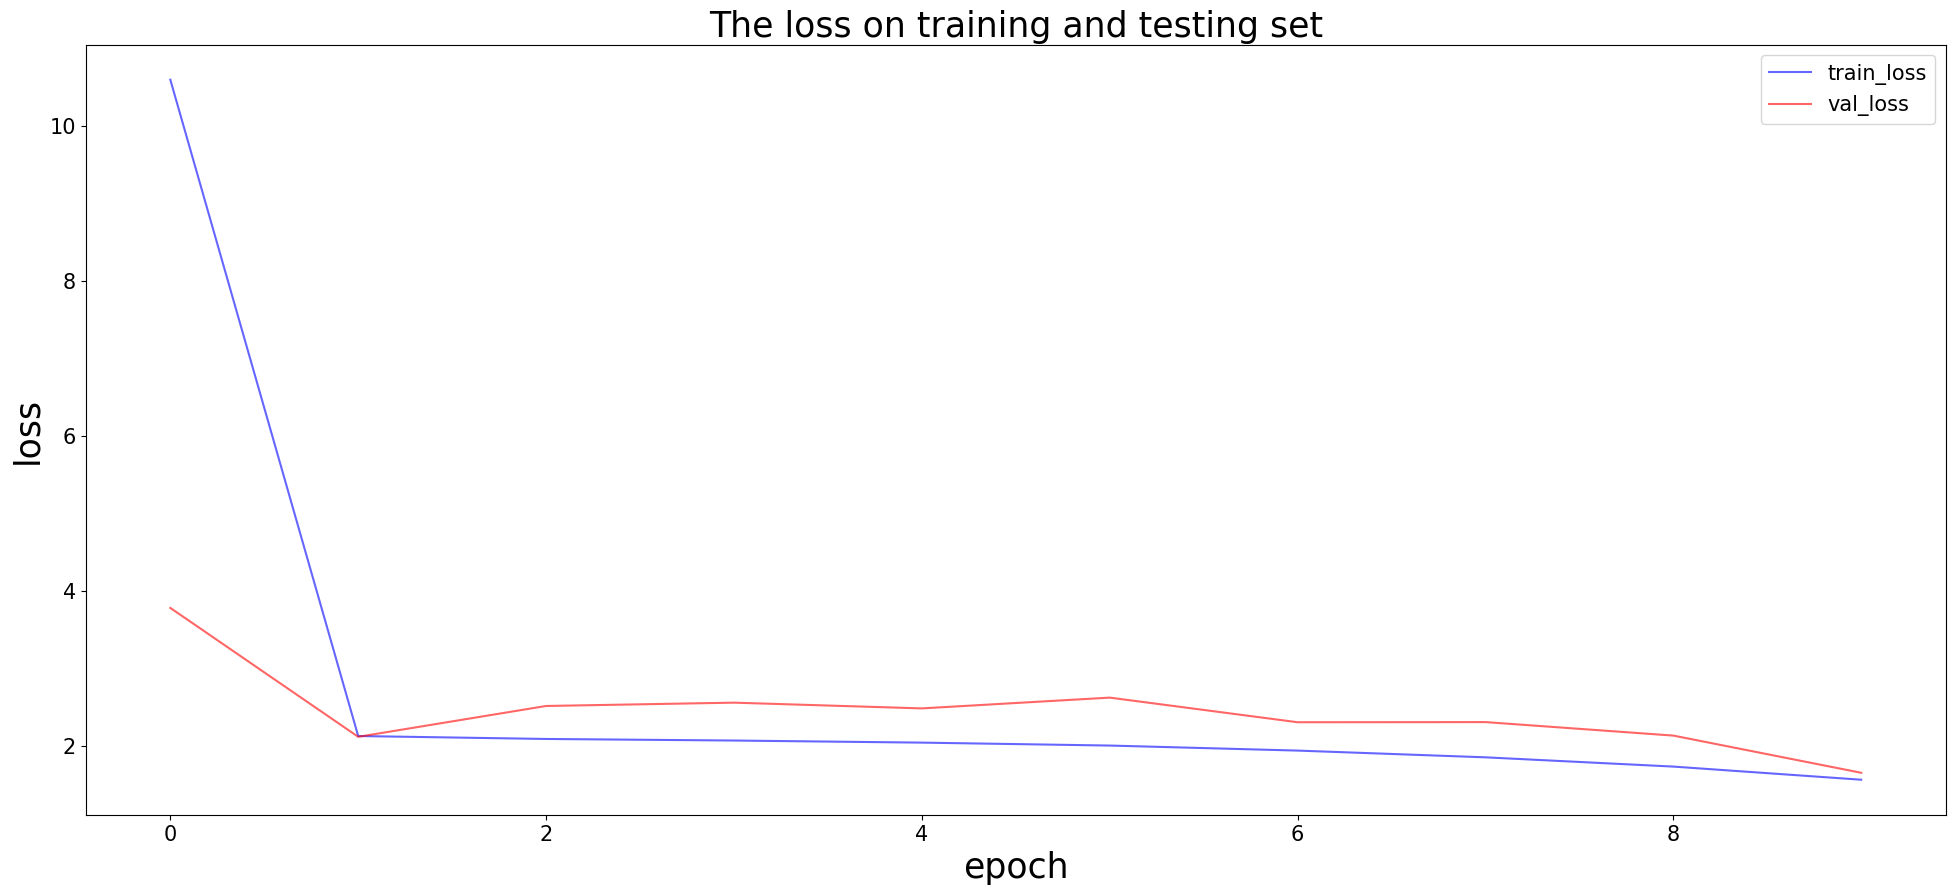

In [297]:
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('The loss on training and testing set',fontsize=25)
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch',fontsize=25 )
    plt.ylabel( 'loss',fontsize=25 )
    plt.xticks(fontsize=15 )
    plt.yticks(fontsize=15 )
    plt.legend(fontsize=15 )

train_loss = m.history['loss']
val_loss = m.history['val_loss']

plot_losses(train_loss, val_loss)

In [298]:
model_path = "./lstm.hdf5"
model = load_model(model_path)

pred = model.predict(test_data).reshape(-1)

126/126 [==============================] - 9s 66ms/step


In [299]:
i = 270
print(pred[i])
print(test_target[i])

3.801047
1


In [300]:
def rmse_loss(y_predict, y):
    return sqrt(np.mean(np.square(y_predict - y))) 

def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y))

rmse_loss = rmse_loss(pred, test_target)
mae_loss = mae_loss(pred, test_target)
print('Root Mean square error on test set: ', rmse_loss)
print('Mean absolute error on the test set: ', mae_loss)
# Root Mean square error on test set:  1.1204180827539099
# Mean absolute error on the test set:  0.7932159740924836

Root Mean square error on test set:  1.167516066430708
Mean absolute error on the test set:  0.9668687137395954


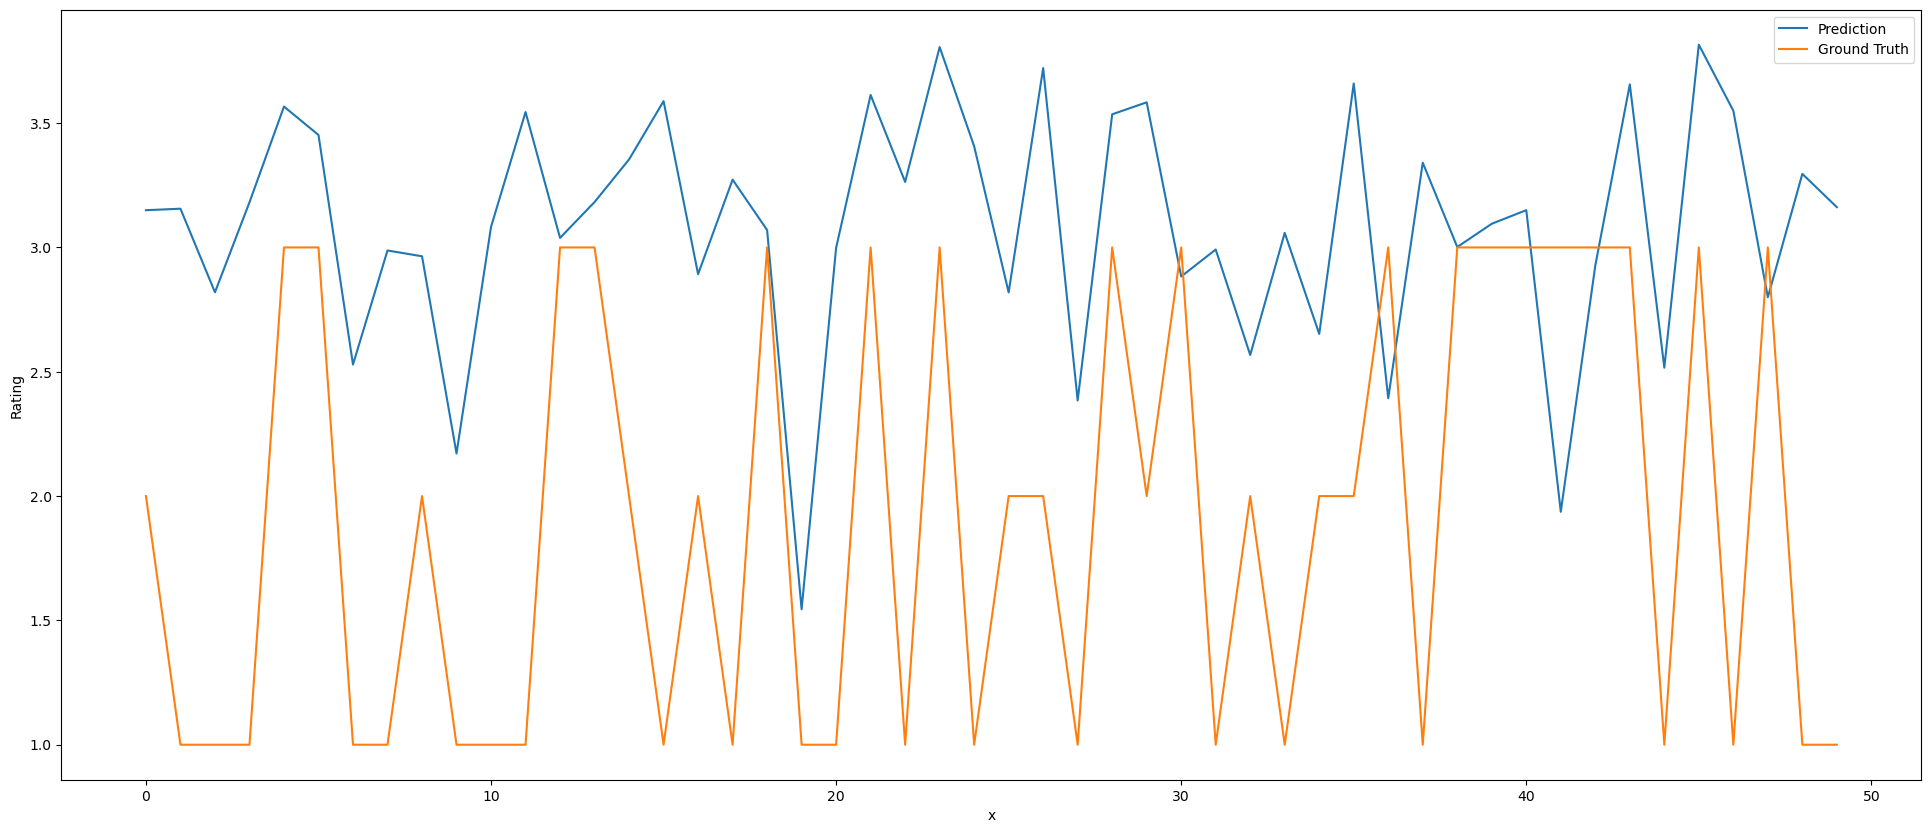

In [301]:
fig, axes = plt.subplots(figsize=(24, 10) )
rng = 50
prediction = pred[:rng]
actual = test_target[:rng]
axes.plot(prediction, label = 'Prediction')
axes.plot(actual, label = 'Ground Truth')
plt.xlabel('x')
plt.ylabel('Rating')
plt.legend()

## As shown in the plot, the model seems to have a good prediction on high ratings, this may due to the larger
##number of high ratings sample in the dataset

In [213]:
#plot the number of the ratings
tar_count = Counter()
for rating in ratings:
    tar_count[rating]+=1

num_tar = len(tar_count)
print(num_tar)
tar_count

# As shown in the results, rating of 5 has a large proportion of the total data,
#may consider to reduce it to have a even amount across all ratings (which also can reduce the number of training
#data and training time)

5


Counter({5: 4011, 2: 4011, 1: 4011, 4: 4011, 3: 4011})